In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.5.1+cu121
True
NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import numpy, pandas, cv2, torch
print("All good")

All good


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
#WTIH ALBUMENTATION's GIVEN OVER HERE..

In [6]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
from PIL import Image
from tqdm.auto import tqdm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
transform = transforms.Compose([transforms.ToTensor() , transforms.Normalize((0.1307,),(0.3081,))]) 
#why this no idea


Getting and Loading the Dataset

In [83]:
from torch.utils.data import Subset #to limimt the dataset we are trying to send to the network

In [84]:
train_limit = 5000
test_limit = 1000

In [15]:
train_dataset = datasets.MNIST(root = "./data" , train = True , download = True , transform=transform)
test_dataset = datasets.MNIST(root = "./data" , train = False , download = True , transform=transform)

train_dataset_small = Subset(train_dataset, range(train_limit))
test_dataset_small = Subset(test_dataset, range(test_limit))

#test and train loader-->
train_loader = DataLoader(train_dataset , batch_size = 64 , shuffle = True)
test_loader = DataLoader(test_dataset , batch_size = 64 , shuffle = False) #no need for shuffle when testing

NOW TIME FOR MAKING THE DENSE NETWORK

In [49]:
class DenseNN(nn.Module):
    def __init__(self):
        super(DenseNN,self).__init__()
        
        self.fc1 = nn.Linear(28*28 , 256)
        self.fc2 = nn.Linear(256 , 128)
        self.fc3 = nn.Linear(128, 10)
        
        #Activation function
        self.relu = nn.ReLU()
        
    #ONE Full forwards pass what it looks like in this
    def forward(self,x):
        # x shape: [batch_size, 1, 28, 28]
        x = x.view(x.size(0), -1)   # Flatten image to [batch_size, 784]
        
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        return x

Making the Model

In [50]:
model = DenseNN().to(device) #note this to(device) keyword is very important for pytorch

Adding the Loss Fn , Optimizer and Learning Rate

In [51]:
# CrossEntropyLoss = LogSoftmax + NLLLoss
criterion = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters() , lr = 0.01) #adam optimizer algorithms for training model params

Writing the training Loop for one epoch over here

In [55]:
def train_one_epoch(model , loader):
    model.train() #pythorch command to set model to training mode
    total_loss = 0.0
    
    for images , labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() #to clear previous gradeints so that we get new one again after each 
        
        outputs = model(images)  #Forward pass made over here
        
        loss = criterion(outputs , labels) #loss function loss calculated
        
        loss.backward()       #Backpropogation step mentioned
        optimizer.step()    #update of the weights and biases
        
        total_loss += loss.item()  #what ??
    avg_loss = total_loss / len(loader)
    return avg_loss  #returning and average loss function ??

Evaluation Fucntion Written Over Here

In [63]:
def evaluate(model , loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images , labels in loader:
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predictions = torch.argmax(outputs , dim = 1) # make the argmax based ont he column of the n*1
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
    accuracy = correct / total
    return accuracy

Training Loop

In [64]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader)
    test_accuracy = evaluate(model, test_loader)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Test Accuracy: {test_accuracy:.4f}"
    )


Epoch [1/10] | Train Loss: 0.1665 | Test Accuracy: 0.9510
Epoch [2/10] | Train Loss: 0.1632 | Test Accuracy: 0.9524
Epoch [3/10] | Train Loss: 0.1489 | Test Accuracy: 0.9607
Epoch [4/10] | Train Loss: 0.1415 | Test Accuracy: 0.9562
Epoch [5/10] | Train Loss: 0.1391 | Test Accuracy: 0.9563
Epoch [6/10] | Train Loss: 0.1324 | Test Accuracy: 0.9589
Epoch [7/10] | Train Loss: 0.1212 | Test Accuracy: 0.9624
Epoch [8/10] | Train Loss: 0.1249 | Test Accuracy: 0.9590
Epoch [9/10] | Train Loss: 0.1267 | Test Accuracy: 0.9622
Epoch [10/10] | Train Loss: 0.1063 | Test Accuracy: 0.9540


Evaluation of the Model on the test data

In [66]:
final_accuracy = evaluate(model , test_loader)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")


Final Test Accuracy: 0.9540


In [67]:
#Inference Example
model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

In [68]:
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

print("\nSample Predictions:", preds[:10].cpu().numpy())
print("Ground Truth     :", labels[:10].numpy())


Sample Predictions: [7 2 1 0 4 1 4 9 6 9]
Ground Truth     : [7 2 1 0 4 1 4 9 5 9]


Now making a new Layer With A Few New Features added to the Net

In [81]:
full_dataset = datasets.MNIST(root="./data",train=True,download=True,transform=transform)

#MODEL DEFINITION

In [94]:
DATA_LIMIT = 20000  # laptop-safe
dataset = Subset(full_dataset, range(DATA_LIMIT))

In [95]:
class DenseNN_V2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(28*28 , 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(256 , 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(128,10)
        )
        
    #ONE Full forwards pass what it looks like in this
    def forward(self,x):
        # x shape: [batch_size, 1, 28, 28]
        x = x.view(x.size(0), -1)   # Flatten image to [batch_size, 784]
        return self.net(x)

In [96]:
model1 = DenseNN_V2().to(device)

In [97]:
def train(model , loader , optimizer , criterion):
    model.train()
    total_loss = 0
    
    for x , y in loader:
        x , y = x.to(device) , y.to(device)
        optimizer.zero_grad() # clear previous grads 
        out = model(x) #forward propogation
        loss = criterion(out,y) #loss eval
        loss.backward() #backwardprop
        optimizer.step() #adjustment of weights , biases
        
        total_loss += loss.item()
    return total_loss / len(loader)
        

In [98]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = torch.argmax(model(x), dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total #gives the accuracy of the correct predicted values

NOW WE ARE ADDING A CROSS-VALIDATION STEP OVER HERE FRO US TO USE TO SOLVE THIS...

In [99]:
from sklearn.model_selection import KFold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [100]:
criterion = nn.CrossEntropyLoss()
epochs = 3
batch_size = 64
fold_accuracies = []

In [101]:
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\n===== Fold {fold+1}/{k_folds} =====")
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)  # L2 regularization)
    
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, criterion)
        acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1} | Loss: {loss:.4f} | Val Acc: {acc:.4f}")

    fold_accuracies.append(acc)


===== Fold 1/5 =====
Epoch 1 | Loss: 0.0679 | Val Acc: 0.9855
Epoch 2 | Loss: 0.0426 | Val Acc: 0.9858
Epoch 3 | Loss: 0.0314 | Val Acc: 0.9858

===== Fold 2/5 =====
Epoch 1 | Loss: 0.0357 | Val Acc: 0.9898
Epoch 2 | Loss: 0.0252 | Val Acc: 0.9915
Epoch 3 | Loss: 0.0183 | Val Acc: 0.9902

===== Fold 3/5 =====
Epoch 1 | Loss: 0.0246 | Val Acc: 0.9952
Epoch 2 | Loss: 0.0166 | Val Acc: 0.9925
Epoch 3 | Loss: 0.0119 | Val Acc: 0.9902

===== Fold 4/5 =====
Epoch 1 | Loss: 0.0179 | Val Acc: 0.9950
Epoch 2 | Loss: 0.0088 | Val Acc: 0.9945
Epoch 3 | Loss: 0.0063 | Val Acc: 0.9932

===== Fold 5/5 =====
Epoch 1 | Loss: 0.0161 | Val Acc: 0.9972
Epoch 2 | Loss: 0.0060 | Val Acc: 0.9948
Epoch 3 | Loss: 0.0058 | Val Acc: 0.9912


In [93]:
print("\nCross-Validation Accuracy:", np.mean(fold_accuracies))


Cross-Validation Accuracy: 0.984


In [108]:
def visualize_predictions(model, loader, num_images=10):
    model.eval() #model out of training mode

    images, labels = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)

        # MNIST image: [1, 28, 28] → [28, 28]
        img = images[i].squeeze()

        plt.imshow(img, cmap="gray")
        plt.axis("off")

        color = "green" if preds[i] == labels[i] else "red"
        plt.title(
            f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}",
            color=color
        )
    plt.tight_layout()
    plt.show()

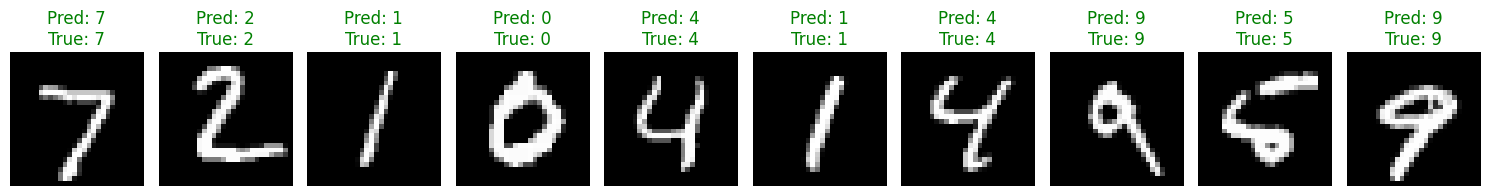

In [109]:
visualize_predictions(model, test_loader, num_images=10)

In [120]:
import random

def predict_random_images(model, dataset, num_images=10):
    model.eval()

    # Randomly sample indices
    indices = random.sample(range(len(dataset)), num_images)

    images = []
    labels = []

    for idx in indices:
        img, label = dataset[idx]
        images.append(img)
        labels.append(label)

    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()
    probs = probs.cpu()

    plt.figure(figsize=(15, 4))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        
        #.squueze() The .squeeze() function (available in libraries like NumPy and PyTorch) automatically removes all 
        #dimensions that have a size of 1. This makes the array conform to the 2D or 3D shape that image display functions expect. 
        img = images[i].squeeze()
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        confidence = probs[i][preds[i]].item()
        color = "green" if preds[i] == labels[i] else "red"

        plt.title(
            f"Pred: {preds[i].item()} ({confidence:.2f})\nTrue: {labels[i].item()}",
            color=color
        )

    plt.tight_layout()
    plt.show()


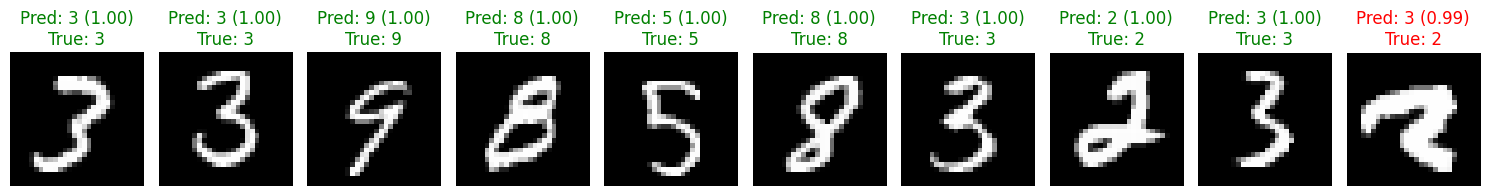

In [125]:
predict_random_images(model, test_dataset, num_images=10)

In [139]:
def predict_wrong_images(model, loader , num_images=10):
    model.eval()

    mis_images = []
    mis_labels = []
    mis_preds = []
    mis_confs = []

    with torch.no_grad():
        for images , labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs , dim=1)
            pred = torch.argmax(probs , dim = 1)
            
            wrong_mask = pred!=labels
            
            if wrong_mask.any():
                for i in range(images.size(0)): #1st dim is no of images
                    if wrong_mask[i]:
                        mis_images.append(images[i].cpu())
                        mis_labels.append(labels[i].item())
                        mis_preds.append(preds[i].item())
                        mis_confs.append(probs[i][preds[i]].item())
                        
                        if(len(mis_images)>num_images):
                            break
            if len(mis_images) >= num_images:
                break
    # Plot results
    rows = int(num_images ** 0.5)
    cols = int(num_images / rows)

    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)

        img = mis_images[i].squeeze()
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        plt.title(
            f"P:{mis_preds[i]} ({mis_confs[i]:.2f})\nT:{mis_labels[i]}",
            color="red",
            fontsize=9
        )
    plt.tight_layout()
    plt.show()


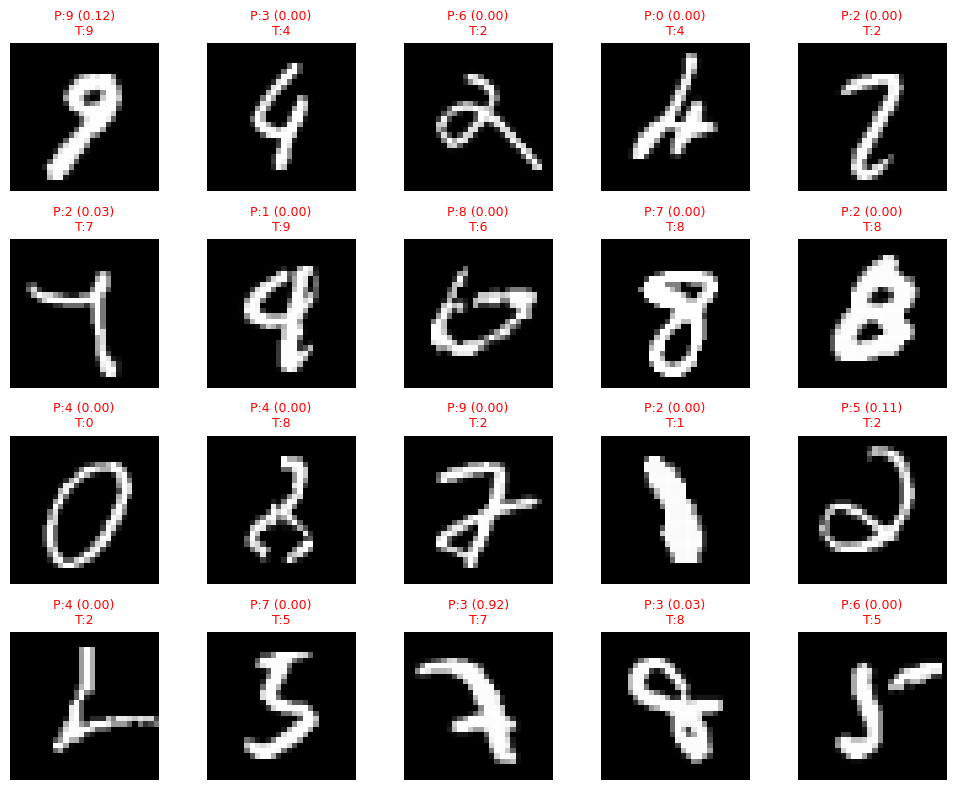

In [141]:
predict_wrong_images(model, test_loader, num_images=20)